In [1]:
using DrWatson
@quickactivate "DeathsOfDespair"

In [2]:
using CairoMakie
using Clustering
using CSV
using DataFrames
using Statistics

In [3]:
df = CSV.read(datadir("exp_pro", "arda_ipums_census.csv"), DataFrame)

Row,geometry,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,ALAND,AWATER,INTPTLAT,INTPTLON,HHINCOME_AVG,PROPTAX_AVG,FOODSTAMP_AVG,State,Black Protestant Adherents,Black Protestant Congregations,Buddhism Adherents,Buddhism Congregations,Catholic Adherents,Catholic Congregations,Evangelical Protestant Adherents,Evangelical Protestant Congregations,Hinduism Adherents,Hinduism Congregations,Islam Adherents,Islam Congregations,Jehovah's Witnesses Adherents,Jehovah's Witnesses Congregations,Judaism Adherents,Judaism Congregations,Latter-day Saints Adherents,Latter-day Saints Congregations,Mainline Protestant Adherents,Mainline Protestant Congregations,Orthodox Adherents,Orthodox Congregations,Other Adherents,Other Congregations,Other Christians Adherents,Other Christians Congregations
,String31,Int64,Int64,Int64,Int64,Int64,String15,String3,Int64,Int64,Float64,Float64,Float64,Float64,Float64,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,Polygon(13638 Points),3,6,1,1779775,1,0400000US01,AL,131185561946,4581813708,32.7396,-86.8434,73663.7,648.106,462.29,Alabama,0,1471,585,11,0,162,4077,2732,0,7,0,37,0,157,375,9,0,77,212,340,828,18,0,12,0,25
2,Polygon(15329 Points),4,9,2,1785533,2,0400000US02,AK,1479508971743,244710526650,63.3474,-152.84,94280.4,2254.97,359.597,Alaska,1179,21,713,12,0,89,4116,709,160,1,400,2,0,31,464,1,0,81,1481,170,808,92,690,14,498,9
3,Polygon(10816 Points),4,8,4,1779777,4,0400000US04,AZ,294366118294,853991999,34.2039,-111.606,75101.4,1015.51,489.473,Arizona,2142,119,0,33,0,269,7116,2852,0,8,0,35,0,306,0,29,0,935,681,436,2442,39,0,44,34,61
4,Polygon(29782 Points),3,7,5,68085,5,0400000US05,AR,134658517854,3122715710,34.8955,-92.4446,69274.7,733.436,419.968,Arkansas,1482,877,100,12,0,129,6105,3706,200,1,0,12,0,134,1086,4,0,71,430,840,1413,14,0,8,600,32
5,Polygon(12103 Points),4,9,6,1779778,6,0400000US06,CA,403673433805,20291632828,37.1552,-119.543,92490.5,2144.59,317.446,California,368,1259,0,499,320,3,9566,6453,0,50,0,308,0,0,0,200,0,8,446,2790,3744,326,0,317,572,279
6,Polygon(7513 Points),4,8,8,1779779,8,0400000US08,CO,268418973518,1185541418,38.9938,-105.509,93898.9,1468.85,263.7,Colorado,1504,99,0,52,0,269,7553,2455,0,2,0,23,0,211,0,19,0,316,524,678,1225,37,0,36,34,58
7,Polygon(3204 Points),1,1,9,1779780,9,0400000US09,CT,12541999507,1816115183,41.5799,-72.7467,1.1211e5,4506.04,275.09,Connecticut,1544,142,455,17,0,361,6416,1162,0,4,0,49,0,133,243,61,0,36,1062,737,4340,59,0,22,0,41
8,Polygon(5345 Points),3,5,10,1779781,10,0400000US10,DE,5046692239,1399219008,38.9986,-75.4416,83628.7,2354.49,353.252,Delaware,3847,83,567,4,0,45,6605,483,0,3,0,9,0,38,543,5,0,12,1115,249,1073,7,293,7,40,11
9,Polygon(20603 Points),3,5,12,294478,12,0400000US12,FL,138965379385,45968913048,28.399,-82.5143,76914.8,2396.99,359.767,Florida,563,1499,0,90,0,561,6923,4928,0,32,0,157,0,0,297,146,0,278,641,1810,3863,172,0,88,274,203


In [22]:
# drop non-numeric and geographic columns
exclude_columns = [:geometry, :State, :GEOID, :STUSPS, :GEOIDFQ, :REGION, :DIVISION, :STATEFP, :STATENS]
data = df[:, Not(exclude_columns)]

50×33 Matrix{Float64}:
 1.31186e11  4.58181e9   32.7396  …   18.0    0.0   12.0    0.0   25.0
 1.47951e12  2.44711e11  63.3474      92.0  690.0   14.0  498.0    9.0
 2.94366e11  8.53992e8   34.2039      39.0    0.0   44.0   34.0   61.0
 1.34659e11  3.12272e9   34.8955      14.0    0.0    8.0  600.0   32.0
 4.03673e11  2.02916e10  37.1552     326.0    0.0  317.0  572.0  279.0
 2.68419e11  1.18554e9   38.9938  …   37.0    0.0   36.0   34.0   58.0
 1.2542e10   1.81612e9   41.5799      59.0    0.0   22.0    0.0   41.0
 5.04669e9   1.39922e9   38.9986       7.0  293.0    7.0   40.0   11.0
 1.38965e11  4.59689e10  28.399      172.0    0.0   88.0  274.0  203.0
 1.49486e11  4.41922e9   32.6296      59.0    0.0   56.0  161.0   57.0
 1.66344e10  1.17774e10  19.8282  …   12.0  869.0   36.0  146.0    7.0
 2.14051e11  2.391e9     44.3484       9.0  871.0   11.0  733.0   16.0
 1.43778e11  6.21685e9   40.1029     122.0    0.0   46.0    4.0   95.0
 ⋮                                ⋱                  ⋮

[1.0 0.7723468219922973 0.43675911604310125 -0.6258315746179249 -0.05303882174443769 -0.12193986536988508 0.001262562864406179 -0.07240776233570899 0.0330994399742477 0.10867857168228348 0.12853770383777346 0.0677159487729803 -0.19195878868707847 -0.13213328282248002 0.014166002811264787 0.30834441287257774 0.0461931823404005 0.24448707768927505 0.059076384520941744 NaN -0.20490429656794967 -0.06209658392199088 -0.0752205956447535 NaN 0.25637511568966953 0.08262366845590027 -0.11876387174456973 -0.15726698541757472 0.14915403111849987 0.11926680642877853 0.17333483657508675 0.19741576939318134 0.03904433699032879; 0.7723468219922973 1.0 0.4849812257360923 -0.38323067854451526 0.10813374144351656 0.08886787415420984 0.04471354838964736 -0.09087606658457355 0.03250370362913807 0.08953822256121755 0.04529270127724693 -0.008630630474296649 0.055198145938490595 -0.07929467499204651 0.014674678027911513 0.19794153668409273 0.06539254173643194 0.2117125144906532 0.0761580448633504 NaN -0.0535

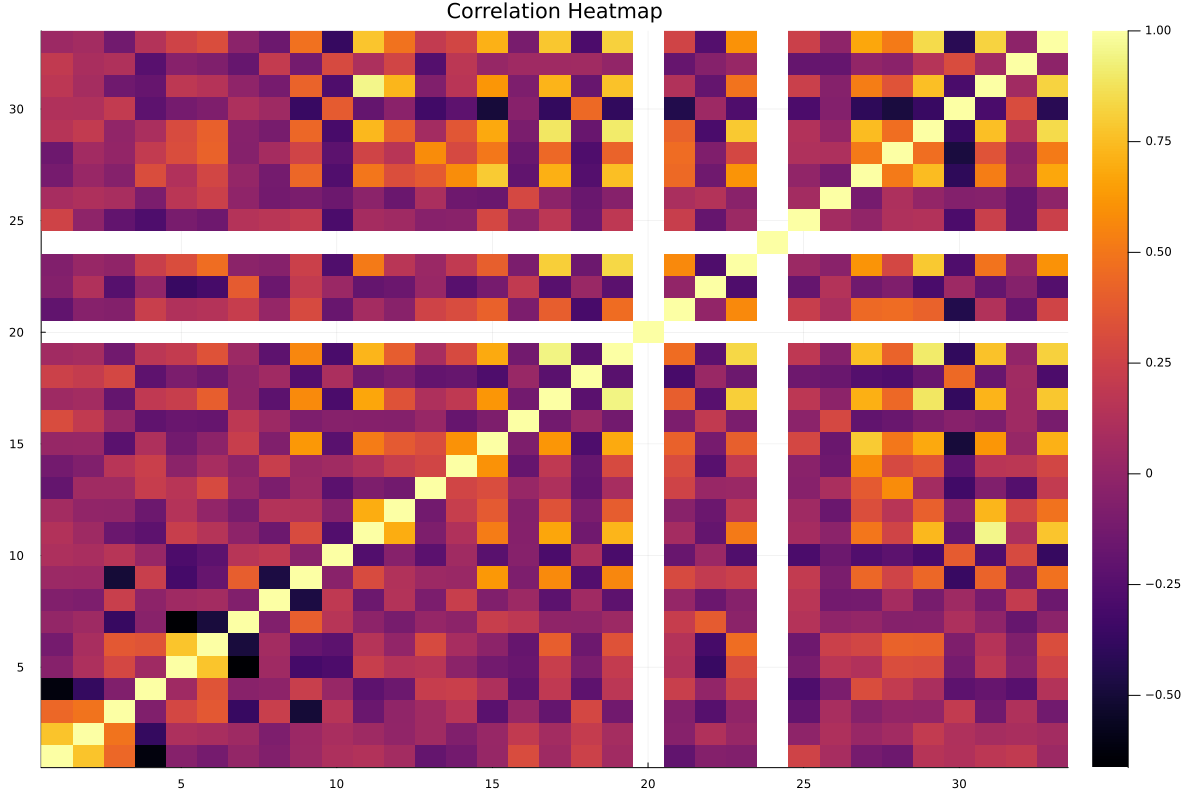

In [23]:
M = cor(Matrix(data))
(n,m) = size(M)

labels = replace.(names(data), "_" => " ") .|> titlecase
fig = Figure(; size = (700, 500));

ax = Axis(fig[1, 1])
Makie.heatmap!(ax, M; colormap = :magma, colorrange = (-1,1))

ax.xticks = (1:m, labels)
ax.xticklabelsize = 8
ax.yticks = (1:m, labels)
ax.yticklabelsize = 8
ax.yreversed = true
ax.xticklabelrotation = π/2

Makie.Colorbar(fig[1, 2], colormap = :magma);

supertitle = Label(fig[0, :], "Correlation Histogram", fontsize = 18)

for i in 1:n
  for j in 1:m
    Makie.text!(ax,
                "$(round(M[i,j],digits=2))",
                position = (i,j),
                align = (:center, :center), 
                fontsize=6,
                color = :black)
  end
end

save(plotsdir("correlation_heatmap.png"), fig)

In [25]:
fig = Figure();
ax = Axis(fig[1, 1], title="Inertia vs. k", xlabel="k", ylabel="Inertia")

for k in 1:10
    # Perform k-means clustering
    model = kmeans(Matrix(data), k)
    println("Iteration: ", k, " inertia: ", model.totalcost)
    # graph inertia
    scatter!(ax, k, model.totalcost, color=:blue, marker=:circle, markersize=5)
end

save(plotsdir("clustering.png"), fig)

Iteration: 1 inertia: 4.023631604437633e24


LoadError: Invalid attributes [31m[1mmarkersize[22m[39m and [31m[1mmarker[22m[39m for plot type [34m[1mLines{Tuple{Vector{Point{2, Float64}}}}[22m[39m.

The available plot attributes for Lines{Tuple{Vector{Point{2, Float64}}}} are:

alpha        cycle            inspector_hover  lowclip      ssao          
clip_planes  depth_shift      inspector_label  miter_limit  transformation
color        fxaa             joinstyle        model        transparency  
colormap     highclip         linecap          nan_color    visible       
colorrange   inspectable      linestyle        overdraw                   
colorscale   inspector_clear  linewidth        space                      

